# Landsat 8 NDVI Analysis on the Cloud using the GEOAnalytics Platform

This notebook demonstrates a "Cloud-native" analysis of [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) using Landsat 8 data. 

This notebook is based directly on https://github.com/pangeo-data/pangeo-example-notebooks/blob/master/landsat8-cog-ndvi.ipynb

**What is unique about this workflow is that no data is downloaded to our local computer! All calculations are performed in memory across many distributed machines on the Google Cloud.** 

This workflow is possible because the Landsat 8 data is stored in [Cloud-Optimized Geotiff](http://www.cogeo.org) format, which can be accessed remotely via [xarray](http://xarray.pydata.org/en/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/) Python libraries. Distributed computing is enabled through a [Pangeo](http://pangeo-data.org) JupyterHub deployment with [Dask Kubernetes](https://github.com/dask/dask-kubernetes).

About Landsat 8:
https://landsat.usgs.gov/landsat-8 

About the Landsat archive:
https://cloud.google.com/storage/docs/public-datasets/landsat

Date: August 30, 2018

Created by:
Scott Henderson (scottyh@uw.edu), Daniel Rothenberg

In [1]:
# Import required libraries
import os
import pandas as pd
import rasterio
import xarray as xr
import requests

from dask_kubernetes import KubeCluster
from dask.distributed import Client
from dask.distributed import wait, progress
from intake import open_stac_catalog

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Print package versions
print('Xarray version: ', xr.__version__)
print('Rasterio version: ', rasterio.__version__)

Xarray version:  0.15.0
Rasterio version:  1.0.25


In [3]:
# Set environment variables for cloud-optimized-geotiffs efficiency
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='YES'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS']='TIF'

## Using GEOAnalytics Canada's SpatioTemporal Asset Catalogue (STAC) to get Landsat 8 images

The [SpatioTemporal Asset Catalog (STAC)](https://stacspec.org/) is an open specification that evolved from different organizations coming together to increase the interoperability of searching for satellite imagery. When a user wants to search for all the imagery in their area and time of interest they can’t make just one search — they have to use different tools and connect to API’s that are similar but all slightly different. STAC aims to make that much easier, by providing common metadata to expose geospatial assets.

In [4]:
def create_dataframe(collection='landsat-8-l1',tier='T1', path=14, row=28):
    all_data = []
    url_template = 'https://stac.geoanalytics.ca/stac/{collection}/landsat:wrs_path/{path}/landsat:wrs_row/{row}/items?limit=50&next={next_token}'
    headers={'cookie': '_oauth2_proxy=eyJBY2Nlc3NUb2tlbiI6ImVYMlI5SVVyU2I2eU5oMVBjVHFXOFFoT2ZVVVN5NWJvTnZ4V3o1bVIvam52WVovRTZxeEpMdEZNWDNkdFNtaWxWRFJnVWRnd09tVmMySlQ1Ykx1d2J1Q1RlVEtkbGF5NTFTRTgzK1RmMGllUXJPWkxlVytyTjA1Z05DZTR0dTlnNXZuWUZkNThuRTRVM01RbW1OM2xWc0U5alZIdmdOUnpDellrRE4vWVdDS09IM0E0emFqTVRHVkhOdGQ1OHkwSmV2cGpMNG9LaWgreEJCOG1XWFVFcFdKNTlPODF1dUFRbmZiWWViTU1FQXBSeG95c2FpalZBQ243QkNiMEcrclJldnhuUzdHNG85WkZzWHFpNWp4WDl2dGxyNzNRbXMyckx4VGRKY0p3S2k1dThUUktwdEhBbGtrcE9kTXpWUHd5eVRueWJRb1loTWxJcUVyeWxTeUE1TGxyMkZQWWxUU3k3VkljTS9pM29JaFJzaHVEYzZ3dUg2UUl6TjBNQjdrTkl4ZVFsMytScFpkZlNvUUNlQVhqYU1NenhkdmsySzc0MStqTlhHZ0lxeWEveDU2N01Tam9nQ05KQ1NrKzJLV2N6N3lIU2l2UXU5Qi82bXN0OGlDVjJEdzBMUnduK0hVUDkrRDJId1R6NGx3Rzd2SmlpcXcwRW1rTFBZUGtlSjVUWDJpdkFNSlgrYWU0ekVZclFEalhVSzJMR01XcXpJQUN3eWdnU1FiVWk3N3JTQTdTOXlHUzhNMXhRQlllaFNtaG5kbFhhNXN2VTZRUGNWU0wvVFJjeGl1cU9iVnhBcUs1VXFSNmNFYlIyOURCK0ZlMHhWWllJSGtXWi9FMHlzTjMrV05YSStXNVdZcVpCcnVhdWpMTHlnbTUvejR4UnlCVzIwSXVYS1FOUkdlSUszLzlnOUI1ajkxWmdYSTZhY2JpK3QxRE1zZS9KbVhVSUtzbG80WkJ2UmZGSmZJVVFrQ3E1ZkFlNWdXOVV2RmFRVmFYNzZuV3diTUJkTnljUUd4eXVQY0x5NTRkU0x2ZFNwTlFMTjRzQzkzaDQ5WGFMZ1NiME5wcXZRN1MvdTQyU0NjRDl2TXUxZDhvYVBUYlBucWhHcmR0STNub3dLeThFQUpoRDdGWFpuOEdqN1gxTS9uc1BoSURjVXMvK0VTWE55MFNPZzB2Sks4VVBjS1NaMWs0dnBEb3ZUQmtWWGtnV1hjZHlZUGNHWmFFY1I0L2t5clRYS3NzNGJQN2ZpYVp3bDVjL2Q3MFBMa1dmMklheDIveHloTHpxdFJZUnUrckowTkNINUIrakVkb2xoYlJKQXptbUswUS9NUEkxRUsraVdlRkpJQ2FEL2RReTdWR2t3dWJHbVJyRE8yOGEwU1dPcUhBTTJjU0ZNeVhvT0VKdFM4Y0dFYzZENnFZaHFkL1hnYzFpSGdTWUpDeFZscVI4QVZQMmdNUnZOTHdmMXdaNWY4VzM1YVZNY28wcmhqYTJGQ0lHUT09IiwiSURUb2tlbiI6IkozNUFFZFhQclRLQ1BScjdlRm83REtVZUJNTE5taVFDR1J3aXIzenlKZTFaSlc2OTM3L2hZMUQ4bXpIZDl3bjk2MUlxR3dLQytja0p0ejFpRWNNMjBla004RUF2eDByMUZucHhibE45cXN1c1hXWWY0TWp1blM0dEVIS3FDMHlLbEVJb3c2R3dxR3ZldmZOVGdVM2FsMmErZnhaUGhNaVpEY3NHcGFBQlFWak9YUGRLUkZDUUl1eUxOZUhyRytQNnNhdFYwT2ZmYkJuaFZxaExOeE03NHlNNlo1WVdSTFV1NHViQmx1dkxJbDRNWWwraG1FN2xvYlI0R0FNb2I4TUZCZW5UOEFRamprcWQ2VktNUlpCTGZGWjZNajQ0ZlNjTUdUK1RjL2lIQXBPMVlqZTY0MU9WOUgwNzA1cGJKZFA5ZHZnTUtadjBqdGRuRTV6cUw2aVpqUUg3RnVUbE9JNmVucDczUHJmRmhmQ0c2TnM4M3VPVDZXU2NhU0Z5TWE4L2xkeWQ5dHVBRzlrcWFNWk1GalptdHhqdFVVQWVqWjB1RGJCN011MDh3ZTU4bFFZUlk1YTFPNXZDS3V0dTJCR0dwYTNXcHBRYWhrSDkxTU9qUnNQZi9KQnlSY1hBT0tCN0djdGI4a2lKeHNjVERVeHFrNDlRdE53OHJVb2dwRGl0WGVseW5Tc0d0VXJzZ1hpZ2NXMGdXYW51KzlBNktvZENpSW0ycTFPNkl6SVBiZXY4aVZhUEJZb3dqY243SkkycWxobGZwQnZGcW5SWWtZSGwyL1BERHh4UlBiMGdMRnRyd0lKOG40VHdZSU5kZWpkdjRQTXVlZEpHNjVnNmNjSTNlM24vUTBQcFV5OTRldnNEMmp0KzZ2dmF6bC93ZEo1UkFVZXdyb3JlV2N6NmlYdVFORzJrclVLSVprMkZpWWphSndNY2N2c2czMEg1Q0dFdjdkeEM5OHlwZDh0ajhzcGlTaWdiMFoyS3ZwM0Y2VWpyemJLZ0NHU09hYlZwYXlKNG5pVUIyVEh6VzhySFcyanpMalFSZ0JsazlCWjQveFgvcE1NVDlpRnNLYi9BQ21OY2FmWlNIR2RIMGw0SU42bUxOS1ZWelo2ZDFNT1RNdG4wSmpxTHBMa0tXenZ2cFhvWEpxUlFJd0VDQ3J4YWRGTWgwKzVrWWVoYUdmME5MRHBnWitKQUJWQnJmY1hNZ01IMnRPY2JWMnhjTHNFUnh0em1HTnpOYmZVV3lFeU54MFYxMFRRbFp3bG5Qa3hvaXJ3WU5odmE2MkRwekdCMlFKVjUwMzN5MlhKblA0dUlXZU51bGthNi9WbUx5OUgrYWJEY0lMMUJ5UGFTcHFVQjZabE5yWTFJVlk2VzRSM0FrM2NvdVhoNXQxVThHWmFCSEhVNUh2VUJ3N1ExUzlNRlpZYmo3MlN1SUFGY0lnRlZPYUtaU0hRY0Y1djk5R01rR2EyNDB5VGZNeHdDOUZzc0hHR2JkZz09IiwiRW1haWwiOiJLNjBPSVY0RU5MVUd5eGx1QkRQbmdMalpKZWE5QTFzdUNJMmh0MzhTTGE2TmRnd1oyV2ZjVkdNPSIsIlVzZXIiOiJnZndhQVc2VGVhTitzSHYrZjFDczFkSkZHVFM2SEJEZStXUjBhMXJUVng3OXdkYkQiLCJDcmVhdGVkQXQiOiIyMDIwLTAzLTE5VDAwOjU0OjMxLjgzMDQ0MzE3NFoiLCJFeHBpcmVzT24iOiIyMDIwLTAzLTIwVDAwOjU0OjMxWiJ9|1584579271|Pe4bXYORCWFjqnPrPLy0g_ySc6s='}
    next_token = ''
    while True:
        try:
            url = url_template.format(collection=collection, path=path, row=row, next_token=next_token)
            r = requests.get(url, headers=headers)
            json_response = r.json()
            for item in json_response['features']:
                all_data.append(item)
            next_token = json_response['search:metadata']['next']
        except Exception as e:
            break
            
    df = pd.DataFrame(all_data, )
    return df


In [5]:
def format_dataframe(pids, assets, bands_to_use):
    dates = [pd.to_datetime(x.split('_')[3]) for x in pids]
    df = pd.DataFrame(dict(product_id=pids, date=dates))
    bands = []
    for band in bands_to_use:
        band_links = []
        for asset in assets:
             band_links.append(asset[band]['href'])
        df[band]=band_links
        
    return df

def format_dataframe_T1(df, bands_to_use):
    T1 = []
    for index, row in df.iterrows():
        if row['id'].endswith('_T1'):
            T1.append(row)
    
    df_T1 = pd.DataFrame(T1)
    pids = df_T1.id.tolist()
    return format_dataframe(pids, df_T1.assets, bands_to_use)


In [6]:
df = create_dataframe()
try:
    assert len(df) > 0
    df = format_dataframe_T1(df, ['B4', 'B5'])
except AssertionError:
    print('OAuth token is invalid. Update it in create_dataframe()')

In [7]:
df.head()

,product_id,date,B4,B5
0,LC08_L1TP_014028_20130414_20170310_01_T1,2013-04-14,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
1,LC08_L1TP_014028_20130430_20170310_01_T1,2013-04-30,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
2,LC08_L1TP_014028_20130601_20170310_01_T1,2013-06-01,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
3,LC08_L1TP_014028_20130719_20170309_01_T1,2013-07-19,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
4,LC08_L1TP_014028_20130804_20170309_01_T1,2013-08-04,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...


## Launch Dask Kubernetes Cluster

This will allow us to distribute our analysis across many machines. In the default configuration for Pangeo Binder, each worker has 2 vCPUs and 7Gb of RAM. It may take several minutes to initialize these workers and make them available to Dask.

In [8]:
# Select 10 'workers' under 'manual scaling' menu below and click 'Scale'
# Click on the 'Dashboard link' to monitor calculation progress
cluster = KubeCluster(n_workers=10)
cluster

In [9]:
# Attach Dask to the cluster
client = Client(cluster)

## Examine a single band Landsat image

The *rasterio* library allows us to read Geotiffs on the web without downloading the entire image. *Xarray* has a built-in load_rasterio() function that allows us to open the file as a DataArray. Xarray also uses Dask for lazy reading, so we want to make sure the native block tiling of the image matches the dask "chunk size". These dask chunks are automatically distributed among all our workers when a computation is requested, so ideally they will fit in the worker memory. A chunk size of 2048x2048 with a float32 datatype implies a 16Mb array.


In [10]:
# Load with rasterio
image_url = df.iloc[0]['B4']
with rasterio.open(image_url) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7601, 'height': 7371, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(30.0, 0.0, 548085.0,
       0.0, -30.0, 5209515.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [11]:
# Note that the blocksize of the image is 256 by 256, so we want xarray to use some multiple of that
xchunk = 2048
ychunk = 2048
da = xr.open_rasterio(image_url, chunks={'band': 1, 'x': xchunk, 'y': ychunk})
da

<xarray.DataArray (band: 1, y: 7371, x: 7601)>
dask.array<open_rasterio-f9a431f9a2817fea3e506f5e9749d209<this-array>, shape=(1, 7371, 7601), dtype=uint16, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.21e+06 5.209e+06 5.209e+06 ... 4.988e+06 4.988e+06
  * x        (x) float64 5.481e+05 5.481e+05 5.482e+05 ... 7.761e+05 7.761e+05
Attributes:
    transform:      (30.0, 0.0, 548085.0, 0.0, -30.0, 5209515.0)
    crs:            +init=epsg:32618
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Point

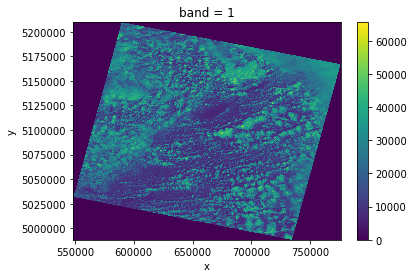

In [12]:
# If we request to compute something or plot these arrays, the necessary data chunks will be accessed on cloud storage:
# Watch the KubeCluster dashboard to see the worker activity when this command is run:
# Note that no data is stored on the disk here, it's all in memory
da.sel(band=1).plot.imshow()

## Load all Landsat bands into an xarray dataset

Often we want to analyze a time series of satellite imagery, but we are constrained by computational resources. So we either download all the images, extract a small subset and then do our analysis. Or, we coarsen the resolution of all our images so that the entire set fits into our computer RAM. Because this notebook is running on Google Cloud with access to many resources in our Kube Cluster, we no longer have to worry about the computational constraints, and can conduct our analysis at full resoution!

First we need to construct an xarray dataset object (which has data variables 'band4' and 'band5' in a n-dimensional array with x-coordinates representing UTM easting, y-coordinates representing UTM northing, and a time coordinate representing the image acquisition date).

There are different ways to go about this, but we will load our images with a timestamp index since each image is taken on a different date. Typically, this is a chore if our images are not on the same grid to begin with, but xarray knows how to automatically align images based on their georeferenced coordinates.

In [13]:
# Note that these landsat images are not necessarily the same shape or on the same grid:
for image_url in df.B4[:5]:
    with rasterio.open(image_url) as src:
        print(src.shape, src.bounds)

(7371, 7601) BoundingBox(left=548085.0, bottom=4988385.0, right=776115.0, top=5209515.0)
(7371, 7601) BoundingBox(left=548385.0, bottom=4988385.0, right=776415.0, top=5209515.0)
(7381, 7601) BoundingBox(left=544485.0, bottom=4988085.0, right=772515.0, top=5209515.0)
(7811, 7691) BoundingBox(left=545985.0, bottom=4981785.0, right=776715.0, top=5216115.0)
(7811, 7691) BoundingBox(left=545085.0, bottom=4981785.0, right=775815.0, top=5216115.0)


In [14]:
def create_multiband_dataset(row, bands=['B4','B5'], chunks={'band': 1, 'x': 2048, 'y': 2048}):
    '''A function to load multiple landsat bands into an xarray dataset '''
    
    # Each image is a dataset containing both band4 and band5
    datasets = []
    for band in bands:
        url = row[band]
        da = xr.open_rasterio(url, chunks=chunks)
        da = da.squeeze().drop(labels='band')
        ds = da.to_dataset(name=band)
        datasets.append(ds)

    DS = xr.merge(datasets)
    
    return DS

In [15]:
# Merge all acquisitions into a single large Dataset
datasets = []
dates = []
for i,row in df.iterrows():
    try:
        print('loading...', row.date)
        ds = create_multiband_dataset(row)
        datasets.append(ds)
        dates.append(row.date)
    except Exception as e:
        print('ERROR loading, skipping acquistion!')
        print(e)

loading... 2013-04-14 00:00:00
loading... 2013-04-30 00:00:00
loading... 2013-06-01 00:00:00
loading... 2013-07-19 00:00:00
loading... 2013-08-04 00:00:00
loading... 2013-08-20 00:00:00
loading... 2013-09-05 00:00:00
loading... 2013-09-21 00:00:00
loading... 2013-10-07 00:00:00
loading... 2013-10-23 00:00:00
loading... 2013-11-24 00:00:00
loading... 2013-12-10 00:00:00
loading... 2014-02-12 00:00:00
loading... 2014-02-28 00:00:00
loading... 2014-03-16 00:00:00
loading... 2014-04-01 00:00:00
loading... 2014-04-17 00:00:00
loading... 2014-05-19 00:00:00
loading... 2014-06-04 00:00:00
loading... 2014-06-20 00:00:00
loading... 2014-07-06 00:00:00
loading... 2014-07-22 00:00:00
loading... 2014-08-07 00:00:00
loading... 2014-08-23 00:00:00
loading... 2014-09-08 00:00:00
loading... 2014-09-24 00:00:00
loading... 2014-10-10 00:00:00
loading... 2014-11-11 00:00:00
loading... 2014-11-27 00:00:00
loading... 2014-12-13 00:00:00
loading... 2014-12-29 00:00:00
loading... 2015-01-14 00:00:00
loading.

In [16]:
# dates
dateslist = df.date.tolist()
dateslist

[Timestamp('2013-04-14 00:00:00'),
 Timestamp('2013-04-30 00:00:00'),
 Timestamp('2013-06-01 00:00:00'),
 Timestamp('2013-07-19 00:00:00'),
 Timestamp('2013-08-04 00:00:00'),
 Timestamp('2013-08-20 00:00:00'),
 Timestamp('2013-09-05 00:00:00'),
 Timestamp('2013-09-21 00:00:00'),
 Timestamp('2013-10-07 00:00:00'),
 Timestamp('2013-10-23 00:00:00'),
 Timestamp('2013-11-24 00:00:00'),
 Timestamp('2013-12-10 00:00:00'),
 Timestamp('2014-02-12 00:00:00'),
 Timestamp('2014-02-28 00:00:00'),
 Timestamp('2014-03-16 00:00:00'),
 Timestamp('2014-04-01 00:00:00'),
 Timestamp('2014-04-17 00:00:00'),
 Timestamp('2014-05-19 00:00:00'),
 Timestamp('2014-06-04 00:00:00'),
 Timestamp('2014-06-20 00:00:00'),
 Timestamp('2014-07-06 00:00:00'),
 Timestamp('2014-07-22 00:00:00'),
 Timestamp('2014-08-07 00:00:00'),
 Timestamp('2014-08-23 00:00:00'),
 Timestamp('2014-09-08 00:00:00'),
 Timestamp('2014-09-24 00:00:00'),
 Timestamp('2014-10-10 00:00:00'),
 Timestamp('2014-11-11 00:00:00'),
 Timestamp('2014-11-

In [17]:
DS = xr.concat(datasets, dim=pd.DatetimeIndex(dates, name='time'))
print('Dataset size (Gb): ', DS.nbytes/1e9)
DS

Dataset size (Gb):  99.85877972


<xarray.Dataset>
Dimensions:  (time: 101, x: 7901, y: 7821)
Coordinates:
  * y        (y) float64 4.982e+06 4.982e+06 4.982e+06 ... 5.216e+06 5.216e+06
  * x        (x) float64 5.415e+05 5.415e+05 5.416e+05 ... 7.785e+05 7.785e+05
  * time     (time) datetime64[ns] 2013-04-14 2013-04-30 ... 2019-12-11
Data variables:
    B4       (time, y, x) float64 dask.array<chunksize=(1, 1457, 2048), meta=np.ndarray>
    B5       (time, y, x) float64 dask.array<chunksize=(1, 1457, 2048), meta=np.ndarray>

### Note that xarray has automatically expanded the dimensions to include the maximum extents of all the images, also the chunksize has been automatically adjusted.

There is definitely some room for improvement here from a computational efficiency standpoint - in particular the dask chunks are no longer aligned with the image tiles. This is because each image starts at different coordinates and has different shapes, but xarray uses a single chunk size for the entire datasets. There will also be many zeros in this dataset, so future work could take advantage of sparse arrays. 

These points aside, our KubeCluster will automatically parallelize our computations for us, so we can not worry too much about optimal efficiency and just go ahead and run our analysis!

Image size (Gb):  0.494349768


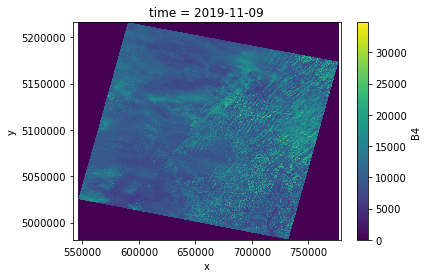

In [18]:
# Here is the syntax to plot the same image as before
# Again, the actually image data is downloaded from cloud storage to memory
da = DS.sel(time='2019-11-09')['B4']
print('Image size (Gb): ', da.nbytes/1e9)
da.plot.imshow()

In [19]:
DS

<xarray.Dataset>
Dimensions:  (time: 101, x: 7901, y: 7821)
Coordinates:
  * y        (y) float64 4.982e+06 4.982e+06 4.982e+06 ... 5.216e+06 5.216e+06
  * x        (x) float64 5.415e+05 5.415e+05 5.416e+05 ... 7.785e+05 7.785e+05
  * time     (time) datetime64[ns] 2013-04-14 2013-04-30 ... 2019-12-11
Data variables:
    B4       (time, y, x) float64 dask.array<chunksize=(1, 1457, 2048), meta=np.ndarray>
    B5       (time, y, x) float64 dask.array<chunksize=(1, 1457, 2048), meta=np.ndarray>

## Distributed NDVI computations

Set up our NDVI dataset. Note that NDVI is not actually computed until we call the Dask compute(), persist(), or call other functions such as plot() that require actually operate on the data!

In [20]:
NDVI = (DS['B5'] - DS['B4']) / (DS['B5'] + DS['B4'])
NDVI

<xarray.DataArray (time: 101, y: 7821, x: 7901)>
dask.array<truediv, shape=(101, 7821, 7901), dtype=float64, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 4.982e+06 4.982e+06 4.982e+06 ... 5.216e+06 5.216e+06
  * x        (x) float64 5.415e+05 5.415e+05 5.416e+05 ... 7.785e+05 7.785e+05
  * time     (time) datetime64[ns] 2013-04-14 2013-04-30 ... 2019-12-11

### Plot NDVI on specific date (full resolution)

Only data for a single landsat acquisition date is pulled from Cloud storage

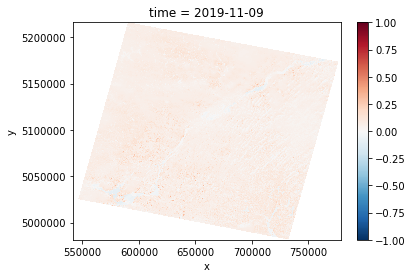

In [21]:
NDVI.sel(time='2019-11-09').plot.imshow()

### Mean NDVI for a range of dates

This example calculates the mean NDVI per-pixel (30m) for 2018-2019, storing result in local RAM

In [22]:
ndvi = NDVI.sel(time=slice('2018-01-01', '2019-01-01')).mean(dim='time').persist()
print('projected dataset size (Gb): ', ndvi.nbytes/1e9)

projected dataset size (Gb):  0.494349768


<xarray.DataArray (y: 7821, x: 7901)>
dask.array<mean_agg-aggregate, shape=(7821, 7901), dtype=float64, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 4.982e+06 4.982e+06 4.982e+06 ... 5.216e+06 5.216e+06
  * x        (x) float64 5.415e+05 5.415e+05 5.416e+05 ... 7.785e+05 7.785e+05


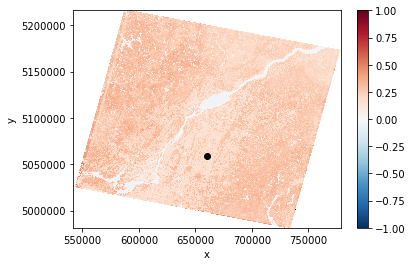

In [23]:
print(ndvi)
ndvi.plot.imshow()

# select a location close to Saint Hyacinthe
# https://www.geoplaner.com
# lat, lon to northing, easting
# 45.66455 --> 660112
# -72.94461--> 5058832
#+ 5 km buffer
#UTM zone 18N
xcen = 660112
ycen = 5058832
plt.plot(xcen, ycen, 'ko')

### Extract region of interest Farmland Saint Hyacinthe and resample to monthly mean average

We expect to see higher NDVI values in the summer months, corresponding to dense vegetation

In [24]:
buf = 5000  # look at point +/- 5km
ds = NDVI.sel(x=slice(xcen-buf,xcen+buf), y=slice(ycen-buf,ycen+buf))
timeseries = ds.resample(time='1MS').mean().persist()

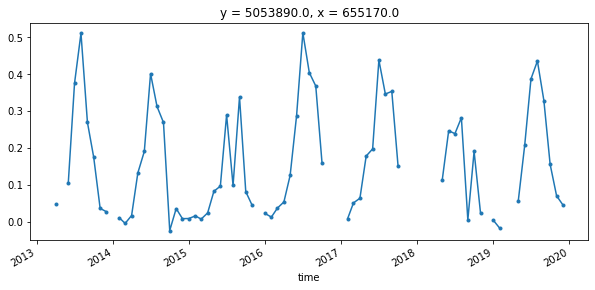

In [25]:
s = timeseries.isel(x=1,y=1)
s.plot(figsize=(10,4), marker='.')

### Plot subset of all NDVI arrays at full resultion for acquisitions in 2018

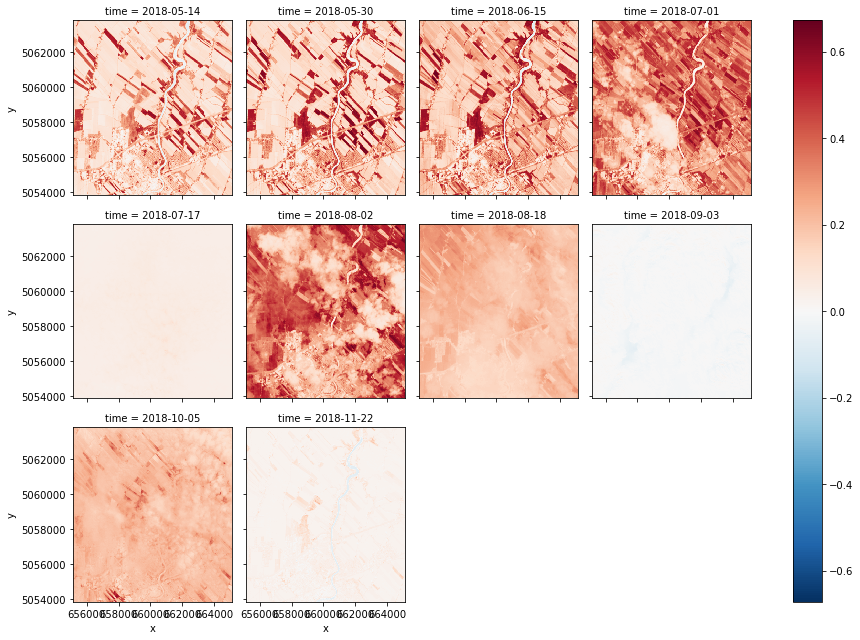

In [26]:
ds.sel(time=slice('2018-01-01', '2019-01-01')).plot.imshow('x', 'y', col='time', col_wrap=4)

## In conclusion

* This notebook demonstrates the power of storing data publically in the Cloud as optimized geotiffs - scientists can conduct scalable analysis without downloading the data to a local machine. Only derived subsets and figures need to be downloaded!
* We used a crude NDVI calculation, designed to demonstrate the syntax and tools - a proper analysis should take into account cloud masks and other corrections